# Boosting para el dataset EuroSAT

# 1. Acceso a drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Importando módulos

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import cv2
import random
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA

# 3. Lectura de los datos

In [ ]:
path = r'/content/drive/Shareddrives/Data Science para Geociencias/6. Métodos de ML/6.2 Árbol de decisión'
train_path = os.path.join(path,'EUROSAT_TRAIN_FEAT.csv')

In [ ]:
train_df = pd.read_csv(train_path)
clases = train_df['label'].unique()
train_df.head()

,histogram_0,histogram_1,histogram_2,histogram_3,histogram_4,histogram_5,histogram_6,histogram_7,histogram_8,histogram_9,histogram_10,histogram_11,histogram_12,histogram_13,histogram_14,histogram_15,histogram_16,histogram_17,histogram_18,histogram_19,histogram_20,histogram_21,histogram_22,histogram_23,histogram_24,histogram_25,histogram_26,histogram_27,histogram_28,histogram_29,histogram_30,histogram_31,histogram_32,histogram_33,histogram_34,histogram_35,histogram_36,histogram_37,histogram_38,histogram_39,...,histogram_493,histogram_494,histogram_495,histogram_496,histogram_497,histogram_498,histogram_499,histogram_500,histogram_501,histogram_502,histogram_503,histogram_504,histogram_505,histogram_506,histogram_507,histogram_508,histogram_509,histogram_510,histogram_511,hal_0,hal_1,hal_2,hal_3,hal_4,hal_5,hal_6,hal_7,hal_8,hal_9,hal_10,hal_11,hal_12,hum_0,hum_1,hum_2,hum_3,hum_4,hum_5,hum_6,label
0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012692,8.819525,0.606407,11.202328,0.411772,112.869246,35.989785,4.587024,6.990196,0.002292,2.686005,-0.132405,0.783513,0.002973,6.369633e-10,1.516469e-13,7.302349e-13,9.142081e-26,8.576981e-18,-2.251498e-25,Forest
1,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016780,6.737624,0.523612,7.070943,0.395274,113.673990,21.546147,4.192914,6.515763,0.002552,2.556843,-0.087996,0.659967,0.002942,2.693041e-10,9.678997e-15,7.353245e-13,1.652979e-26,1.191183e-17,5.979175e-26,Forest
2,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025098,4.159946,0.587513,5.044265,0.489949,105.225032,16.017115,4.011338,5.961651,0.003509,2.247017,-0.124186,0.727920,0.003155,4.341931e-10,1.849652e-12,2.115307e-13,-1.071065e-25,3.151259e-19,7.768625e-26,Forest
3,0.0,0.0,0.0,0.000718,0.00395,0.001436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022486,50.834805,0.744700,99.422595,0.436835,117.787398,346.855576,4.579942,6.767477,0.001086,2.938769,-0.190203,0.866096,0.002811,4.023647e-09,7.724173e-12,3.490115e-12,-1.568084e-23,6.745461e-17,9.082255e-24,Forest
4,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007640,12.731279,0.589228,15.496675,0.334405,113.976952,49.255423,4.815528,7.530149,0.001799,2.969903,-0.106116,0.746747,0.002936,4.838209e-10,3.726097e-12,5.626374e-12,2.496585e-23,1.228961e-16,-6.352761e-24,Forest


In [ ]:
clases = train_df['label'].unique().tolist()
n_clases = len(clases)
print(clases)

['Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Cálculo de los pesos

In [ ]:
pesos = train_df['label'].value_counts().sort_index().tolist()/ np.sum(train_df['label'].value_counts().tolist())
print(pesos)

[0.125      0.125      0.10416667 0.10416667 0.08333333 0.10416667
 0.125      0.10416667 0.125     ]


# 3. Codificación de las etiquetas y escalamiento

In [ ]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df.label.values)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_df.loc[:, train_df.columns != 'label'] = scaler.fit_transform(train_df.loc[:, train_df.columns != 'label'])

# 4. Análisis de componentes principales

In [ ]:
pca = PCA(0.8)
pc = pca.fit_transform(train_df.iloc[:,:-1])
df_pca = pd.DataFrame(data = pc,
                           columns=range(pc.shape[1]))
df_pca = pd.concat([df_pca, train_df.iloc[:,-1]], axis = 1)

In [ ]:
print('Número de componentes principales: %s'%len(pca.explained_variance_ratio_))
print('Varianza acumulada con %s componentes: %s'%(len(pca.explained_variance_ratio_),np.sum(pca.explained_variance_ratio_)))

Número de componentes principales: 13
Varianza acumulada con 13 componentes: 0.8026552764879361


In [ ]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,label
0,0.794936,-0.309045,-0.034182,0.472750,0.104407,-0.103815,-0.128473,-0.061032,0.064459,0.072393,0.088103,0.056799,0.042715,0
1,0.902883,-0.171158,0.082851,0.504755,-0.139262,-0.128761,-0.117520,-0.183206,0.052243,0.073681,0.072478,0.086872,0.062678,0
2,0.988506,-0.217424,0.033294,0.475327,-0.042156,-0.084267,-0.081708,-0.049299,0.047954,0.031502,0.058258,0.060630,0.038480,0
3,0.713198,-0.308842,-0.103465,0.525621,-0.021424,-0.066784,-0.009050,0.004468,0.023701,0.029169,0.023041,0.025966,0.014983,0
4,0.682355,-0.368111,-0.044976,0.383385,0.298409,-0.134437,-0.238336,-0.093024,0.096360,0.121753,0.128168,0.066764,0.062802,0


# 5. Evaluación para los modelos

In [ ]:
def plot_confusion_matrix(cm, classes, tit, normalize=False):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)
        title, fmt = 'Matriz de confusión normalizada', '.2f'
    else:
        title, fmt = tit, 'd'
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)#, fontsize=12)
    plt.colorbar(pad=0.05)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=40)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Clase Verdadera')#, fontsize=10)
    plt.xlabel('Clase Predicha')#, fontsize=10)
    plt.savefig(title+'.png')
    plt.grid(False)
    plt.show()

def sens_spec(cls_names, y_true, y_pred, pesos):
  sensitivity = []
  specificity = []
  prec=[]
  fscore = []
  sd = []
  for i,name in enumerate(cls_names):
    TP = np.sum((y_true==name) & (y_pred==name))
    TN = np.sum((y_true!=name) & (y_pred!=name))
    FP = np.sum((y_true!=name) & (y_pred==name))
    FN = np.sum((y_true==name) & (y_pred!=name))
    sensitivity.append(TP/(TP+FN))
    specificity.append(FP/(TN+FP))
    prec.append(TP/(TP+FP))
    fscore.append(2*(prec[i]*sensitivity[i])/(prec[i]+sensitivity[i]))
  sensitivity.append(sum([x*y for x,y in zip(sensitivity,pesos)]))
  specificity.append(sum([x*y for x,y in zip(specificity,pesos)]))
  prec.append(sum([x*y for x,y in zip(prec,pesos)]))
  fscore.append(sum([x*y for x,y in zip(fscore,pesos)]))
  for i in range(len(cls_names)):
    sd.append(np.sqrt((sensitivity[i]-sensitivity[-1])**2))
  sd.append(np.nan)
  return sensitivity, specificity, prec, fscore, sd

In [ ]:
X = np.array(train_df.iloc[:,:-1])#(df_pca.iloc[:,:-1])
y = np.array(train_df['label'])#(df_pca['label'])

# 6. Árbol de decisión (baseline)

In [ ]:
cart =  DecisionTreeClassifier(max_depth=5)
kfold = KFold(n_splits=10, shuffle=True)

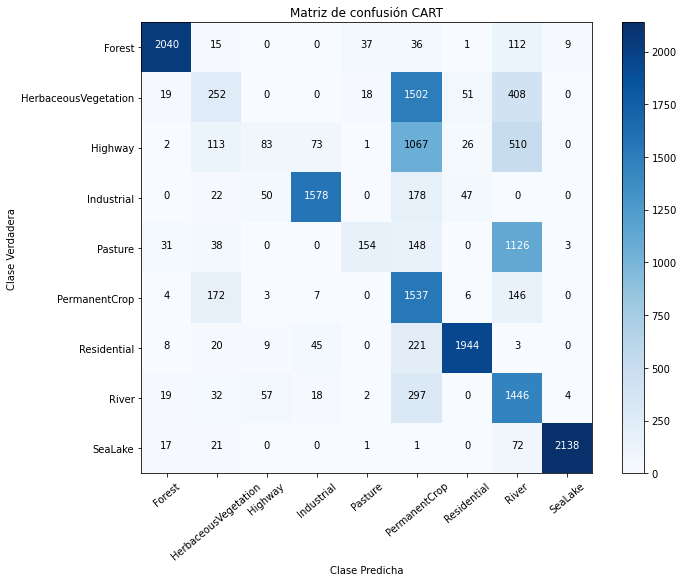

In [ ]:
score = cross_val_score(cart, X, y, cv=kfold, scoring="accuracy")
y_pred = cross_val_predict(cart, X, y, cv=10)
predictions = np.float32(y_pred)
true_labels = np.float32(y)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión CART'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

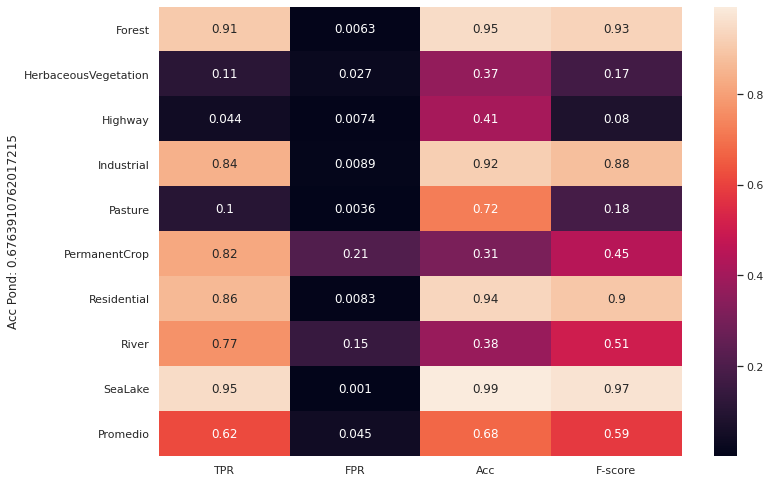

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)

# ¿Cuántos weak learners son necesarios?

In [ ]:
Xclassifiers = []
Yscore = []
kfold = KFold(n_splits=2, shuffle=True)
cart =  DecisionTreeClassifier(max_depth=5)
for i in range(500):
  if i%50 == 0:
    boost = AdaBoostClassifier(base_estimator=cart, n_estimators=i+1)#, random_state=seed, learning_rate=1.5)
    # Ajustando los datos
    score = cross_val_score(boost, X, y, cv=kfold, scoring="accuracy")
    Yscore.append(score)
    Xclassifiers.append(i+1)
    print("iter: %s, score: %s"%(i+1,np.mean(score)))


iter: 1, score: 0.6206666666666667
iter: 51, score: 0.781
iter: 101, score: 0.7962222222222222
iter: 151, score: 0.8045
iter: 201, score: 0.8234444444444444
iter: 251, score: 0.8255
iter: 301, score: 0.8339444444444444
iter: 351, score: 0.8331666666666666
iter: 401, score: 0.8347777777777778
iter: 451, score: 0.8382222222222222


0.8415555555555555


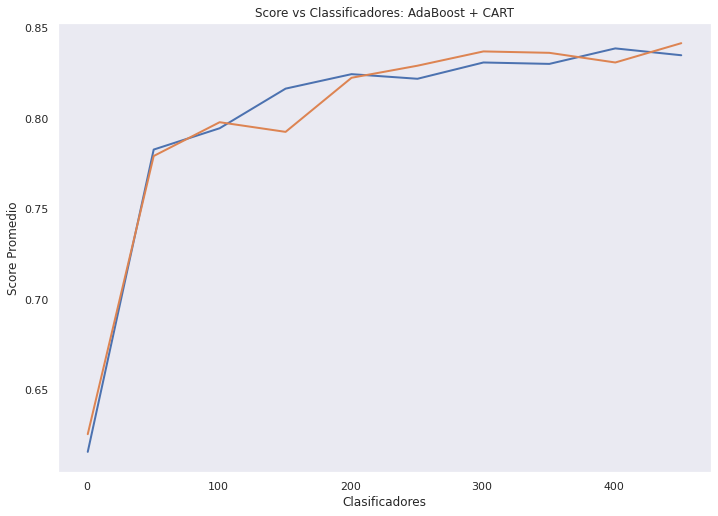

In [ ]:
plt.figure()
plt.plot(Xclassifiers, Yscore,lw=2)
plt.xlabel('Clasificadores')
plt.ylabel('Score Promedio')
plt.title('Score vs Classificadores: AdaBoost + CART')
print(np.max(Yscore))
plt.grid()
plt.show() 

# 7. Boosting con CART

In [ ]:
cart = DecisionTreeClassifier(max_depth=5)
kfold = KFold(n_splits=2, shuffle=True)
boost = AdaBoostClassifier(base_estimator=cart, n_estimators=500)#, learning_rate=1.5)

In [ ]:
score = cross_val_score(boost, X, y, cv=kfold, scoring="accuracy")
print(score)

[0.833      0.84222222]


In [ ]:
y_pred = cross_val_predict(boost, X, y, cv=2)

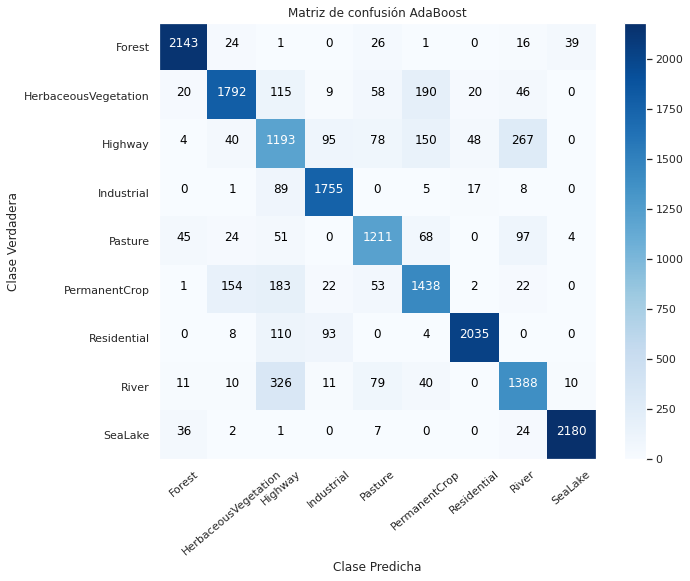

In [ ]:
predictions = np.float32(y_pred)
true_labels = np.float32(y)
cnf_matrix = confusion_matrix(true_labels, predictions, labels=range(n_clases))
tit = 'Matriz de confusión AdaBoost'
plot_confusion_matrix(cnf_matrix,clases, tit, normalize=False)

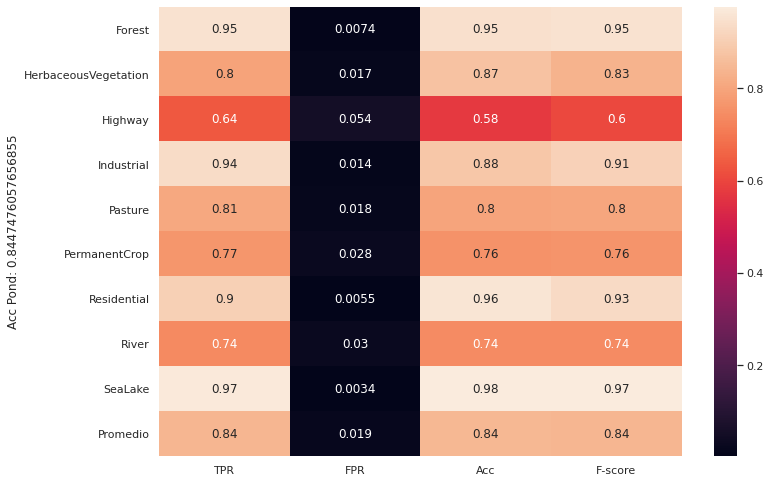

In [ ]:
sensitivity, FPR, prec, fscore, sd = sens_spec(range(n_clases), true_labels, predictions, pesos)
d = {'TPR':sensitivity, 'FPR':FPR, 'Acc':prec, 'F-score':fscore}
ind = clases+['Promedio']
df = pd.DataFrame(d, index=ind)#.transpose()
index = df.index
precprom = sum([x*y for x,y in zip(prec,pesos)])
index.name = 'Acc Pond: %s'%precprom
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df, annot=True)